In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from pandas.io.json import json_normalize

In [2]:
#load csv with results from webscraper
df_hikes = pd.read_csv('Downloads/Datasets/wta_hikes.csv')

#load json object
with open('Downloads/Datasets/wta-parks-data.json') as f:
    df_hikes2 = json.load(f)
    
#normalize coordinates
df_hikes2 = json_normalize(df_hikes2)

#merge the two data sources
df = df_hikes.merge(df_hikes2, left_on='TITLE', right_on='name', how='left')

In [3]:
#clean the dataframe by dropping duplicate and unneeded columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'elevation.Gain', 'name', 'length', 'url', 'elevation.Highest Point'], axis=1, inplace=True)

#renaming columns and making them all uniform
cols = ['title', 'region', 'distance', 'hike_type', 'elevation_gain', 'highest_point', 'rating',
        'rating_count', 'report_date', 'report_count', 'link', 'latitude', 'longitude', 'features',
        'required_pass']

df.columns = cols

#reorder columns
df = df[['title', 'region', 'distance', 'hike_type', 'elevation_gain', 'highest_point', 'features',
         'rating', 'rating_count', 'report_date', 'report_count', 'required_pass', 'latitude', 
         'longitude', 'link']]

#replace all none values as NaN
df.fillna(value=pd.np.nan, inplace=True)

#filter out duplicates with the same name and same region
df.drop_duplicates(['title', 'region'], keep='first', inplace=True)

#double the distance of all of the one-way hikes
df['distance'] = np.where(df['hike_type'] == 'one-way', df['distance'].astype(float)*2, df['distance'])

#replace one-way with roundtrip
df['hike_type'] = df['hike_type'].replace({'one-way':'roundtrip'})

In [4]:
# Get column names
column_names = df.columns
print(column_names)
print("")

# Get column data types
print(df.dtypes)
print("")

#checking how many columns are null
for col in df.columns:
    print(col, df[col].isnull().sum())

Index(['title', 'region', 'distance', 'hike_type', 'elevation_gain',
       'highest_point', 'features', 'rating', 'rating_count', 'report_date',
       'report_count', 'required_pass', 'latitude', 'longitude', 'link'],
      dtype='object')

title              object
region             object
distance          float64
hike_type          object
elevation_gain    float64
highest_point     float64
features           object
rating            float64
rating_count        int64
report_date        object
report_count        int64
required_pass      object
latitude           object
longitude          object
link               object
dtype: object

title 0
region 0
distance 154
hike_type 154
elevation_gain 532
highest_point 441
features 506
rating 0
rating_count 0
report_date 50
report_count 0
required_pass 1093
latitude 764
longitude 764
link 0


In [5]:
#groupby region
num_hikes_per_region = df.groupby(['region'])['title'].count().reset_index(name='count')
num_hikes_per_region.sort_values(by=['count'], ascending=False, inplace=True)

num_hikes_per_region

,region,count
5,North Cascades,398
7,Puget Sound and Islands,299
0,Central Cascades,295
8,Snoqualmie Region,258
6,Olympic Peninsula,256
9,South Cascades,203
4,Mount Rainier Area,198
2,Eastern Washington,188
10,Southwest Washington,157
1,Central Washington,118


Text(0.5, 1.0, 'Number of Hikes in Washington State by Region')

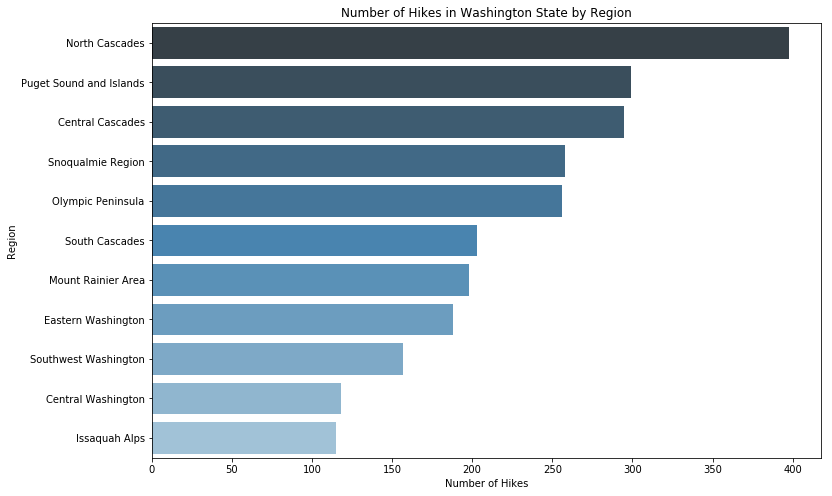

In [6]:
#set plot
f, ax = plt.subplots(figsize=(12, 8))

#render a bar plot of the data grouped by region
sns.barplot(x='count', y='region', data=num_hikes_per_region, palette="Blues_d")

#set labels
ax.set(xlabel='Number of Hikes', ylabel='Region')
ax.set_title('Number of Hikes in Washington State by Region')

count    2485.000000
mean        7.757344
std        18.164159
min         0.000000
25%         1.000000
50%         4.000000
75%         7.000000
max       310.000000
Name: rating_count, dtype: float64

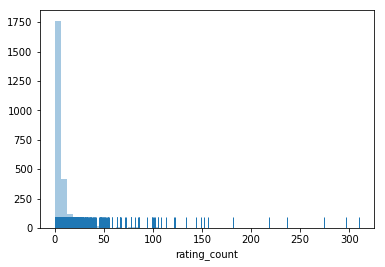

In [7]:
#plot the distribution of rating_count
sns.distplot(df['rating_count'], kde=False, rug=True)

#summary statistics for rating_count
df['rating_count'].describe()

count    2485.000000
mean       64.378270
std       151.865852
min         0.000000
25%         5.000000
50%        17.000000
75%        57.000000
max      1858.000000
Name: report_count, dtype: float64

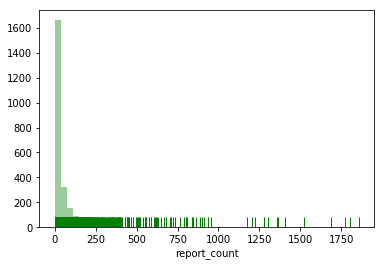

In [8]:
#plot the distribution of report_count
sns.distplot(df['report_count'], kde=False, rug=True, color='g')

#summary statistics for report_count
df['report_count'].describe()

In [9]:
#sort the data by rating_count in increasing order
sorted_rating = sorted(df['rating_count'])

#finding first and third quatiles and using them to calculate the interquartile range
rating_q1, rating_q3= np.percentile(df['rating_count'],[25,75])
rating_iqr = rating_q3 - rating_q1

#establishing upper and lower bounds to identify outliers
rating_lower_bound = rating_q1 -(1.5 * rating_iqr) 
rating_upper_bound = rating_q3 +(1.5 * rating_iqr)

print(rating_lower_bound)
print(rating_upper_bound)

-8.0
16.0


In [10]:
#sort the data by rating_count in increasing order
sorted_report = sorted(df['report_count'])

#finding first and third quatiles and using them to calculate the interquartile range
report_q1, report_q3= np.percentile(df['report_count'],[25,75])
report_iqr = report_q3 - report_q1

#establishing upper and lower bounds to identify outliers
report_lower_bound = report_q1 -(1.5 * report_iqr) 
report_upper_bound = report_q3 +(1.5 * report_iqr)

print(report_lower_bound)
print(report_upper_bound)

-73.0
135.0


In [11]:
#set conditions to evaluate popularity using outlier bounds as well as quartiles as ranking criteria

#5 star popularity
df.loc[(df['report_count'] >= report_upper_bound), 'popularity'] = 5 

#4 star popularity
df.loc[(df['report_count'] < report_upper_bound) & (df['report_count'] >= 58), 'popularity'] = 4

#3 star popularity
df.loc[(df['report_count'] < 58) & (df['report_count'] >= 17), 
       'popularity'] = 3

#2 star popularity
df.loc[(df['report_count'] < 17) & (df['report_count'] >= 5),
       'popularity'] = 2

#1 star popularity
df.loc[(df['report_count'] < 5), 'popularity'] = 1

#group by popularity
df.groupby(['popularity'])['title'].count().reset_index(name='count')

,popularity,count
0,1.0,612
1,2.0,608
2,3.0,645
3,4.0,338
4,5.0,282


In [14]:
#write to csv
df.to_csv('washington_hikes.csv')